In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

In [13]:
class LMDLoss(nn.Module):
  def __init__(self, alpha, beta, gamma, delta_v, delta_d):
    super(LMDLoss, self).__init__()
    self.delta_v = delta_v
    self.delta_d = delta_d
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma

  def _distance(self, point, weight, bias):
    numerator = torch.abs(torch.dot(weight, point) + bias)
    denominator = torch.norm(weight)
    return numerator / denominator

  def _computeCentroids(self, features, labels, unique_labels, momentum=0.99):
    if not hasattr(self, 'centroids'):
      self.centroids = torch.zeros((len(unique_labels), features.size(1)), device=features.device)

    for label in unique_labels:
      mask = (labels == label)
      class_features = features[mask]
      if class_features.size(0) > 0: # Avoid empty classes
        new_centroid = class_features.mean(dim=0)
        self.centroids[label] = (momentum * self.centroids[label] + (1 - momentum) * new_centroid)
    return self.centroids

  def _compactLoss(self, features, labels, unique_labels, centroids):
    # Calculating the compactness loss
    loss = 0.0
    total_samples = features.size(0)
    for i, label in enumerate(unique_labels):
      mask = (labels == label)
      class_features = features[mask]
      if class_features.size(0) > 0:
        centroid = centroids[i]
        distance = torch.norm(class_features - centroid, dim=1)
        hinge_loss = F.relu(distance - self.delta_v)
        loss += torch.mean(hinge_loss ** 2) * class_features.size(0)
    return loss / total_samples if total_samples > 0 else loss

  def _marginLoss(self, features, labels, weights, biases, unique_labels, centroids):
    # Calculate the margin loss
    loss = 0.0
    num_pairs = len(unique_labels) * (len(unique_labels) - 1)
    for i in range(len(unique_labels)):
      for j in range(len(unique_labels)):
        if i != j:
          weight = weights[i] - weights[j]
          bias = biases[i] - biases[j]
          centroid = centroids[i]
          distance = self._distance(centroid, weight, bias)
          sign = torch.sign(torch.dot(weight, centroid) + bias)
          hinge_loss = F.relu(self.delta_d + distance * sign)
          loss += hinge_loss
    return loss / len(unique_labels)

  def _regLoss(self, centroids):
      loss = torch.mean(torch.norm(centroids, dim=1))
      return loss

  def forward(self, features, labels, weights, biases):

    features = F.normalize(features, p=2, dim=1)

    unique_labels = torch.unique(labels)
    centroids = self._computeCentroids(features, labels, unique_labels).detach()

    compact_loss = self._compactLoss(features, labels, unique_labels, centroids)
    margin_loss = self._marginLoss(features, labels, weights, biases, unique_labels, centroids)
    reg_loss = self._regLoss(centroids)
    total_loss = self.alpha * compact_loss + self.beta * margin_loss + self.gamma * reg_loss

    return total_loss


In [3]:
model = models.resnet18(pretrained=True)

# Modify the model to include the penultimate layer
class ModifiedResNet18(nn.Module):
  def __init__(self, model, num_classes):
    super(ModifiedResNet18, self).__init__()
    self.features = nn.Sequential(*list(model.children())[:-1])
    self.fc = nn.Linear(model.fc.in_features, num_classes)

  def forward(self, x):
    x = self.features(x)
    features = torch.flatten(x, 1)
    outputs = self.fc(features)
    return features, outputs

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 214MB/s]


100%|██████████| 170M/170M [00:12<00:00, 13.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
def save_checkpoint(model, optimizer, epoch, train_losses, val_losses, val_accuracy, checkpoint_path):

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracy': val_accuracy
    }
    try:
      torch.save(checkpoint, checkpoint_path)
      print(f"Checkpoint saved at epoch {epoch} to {checkpoint_path}")
    except Exception as e:
      print(f"Failed to save checkpoint: {e}")

def load_checkpoint(model, optimizer, checkpoint_path, device='cpu'):
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found at {checkpoint_path}")

    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        val_accuracy = checkpoint['val_accuracy']
        print(f"Checkpoint loaded from epoch {epoch} with val_accuracy: {val_accuracy:.2f}%")
        return model, optimizer, epoch, train_losses, val_losses, val_accuracy
    except Exception as e:
        raise RuntimeError(f"Failed to load checkpoint: {e}")

In [11]:
def train_model(model, criterion, optimizer, num_epochs, train_loader, test_loader, device, checkpoint_dir):
  train_losses = []
  val_losses = []
  best_val_accuracy = 0.0

  checkpoint_path = os.path.join(checkpoint_dir, "checkpointLMLoss.pth")
  if os.path.exists(checkpoint_path):
    model, optimizer, start_epoch, train_losses, val_losses, best_val_accuracy = load_checkpoint(model, optimizer, checkpoint_path)
    print(f"Resuming training from epoch {start_epoch}")
  else:
    start_epoch = 0

  for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

    for images, labels in progress_bar:

      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      features, outputs = model(images)
      weights = model.fc.weight.detach()
      biases = model.fc.bias.detach()

      lm_loss = criterion(features, labels, weights, biases)
      softmax_loss = nn.CrossEntropyLoss()(outputs, labels)
      loss = lm_loss + softmax_loss
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

    #validation step
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        features, outputs = model(images)
        weights = model.fc.weight.data
        biases = model.fc.bias.data

        lm_loss = criterion(features, labels, weights, biases)
        softmax_loss = nn.CrossEntropyLoss()(outputs, labels)
        loss = lm_loss + softmax_loss
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    save_checkpoint(model, optimizer, epoch + 1, train_loss, val_loss, val_accuracy, checkpoint_path)

    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
      torch.save(model.state_dict(), best_model_path)
      print(f"Best model saved with val_accuracy: {best_val_accuracy:.2f}%")

  return train_losses, val_losses

In [14]:
# Hyperparameters for LMLoss
alpha = .01
beta = .01
gamma = 0.1
delta_v = 1
delta_d = 4

num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model with LMLoss
model_lm = ModifiedResNet18(model, num_classes)
model_lm.to(device)
criterion = LMDLoss(alpha, beta, gamma, delta_v, delta_d)
optimizer = optim.Adam(model_lm.parameters(), lr=0.001)

# Model with CrossEntropyLoss
model_ce = ModifiedResNet18(model, num_classes)
model_ce.to(device)
criterion_ce = nn.CrossEntropyLoss()
optimizer_ce = optim.Adam(model_ce.parameters(), lr=0.001)
checkpoint_dir = "/content/drive/MyDrive/Colab"

In [15]:
num_epochs = 50
train_losses, val_losses = train_model(model_lm, criterion, optimizer, num_epochs, train_loader, val_loader, device, checkpoint_dir)

Epoch [1/50], Loss: 0.9954
Epoch [1/50], Val Loss: 0.8813, Val Accuracy: 86.33%
Checkpoint saved at epoch 1 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth
Best model saved with val_accuracy: 86.33%


Epoch [2/50], Loss: 0.7842
Epoch [2/50], Val Loss: 0.8179, Val Accuracy: 88.59%
Checkpoint saved at epoch 2 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth
Best model saved with val_accuracy: 88.59%


Epoch [3/50], Loss: 0.6832
Epoch [3/50], Val Loss: 0.9068, Val Accuracy: 86.74%
Checkpoint saved at epoch 3 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [4/50], Loss: 0.6210
Epoch [4/50], Val Loss: 0.8359, Val Accuracy: 88.92%
Checkpoint saved at epoch 4 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth
Best model saved with val_accuracy: 88.92%


Epoch [5/50], Loss: 0.5899
Epoch [5/50], Val Loss: 0.8265, Val Accuracy: 89.58%
Checkpoint saved at epoch 5 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth
Best model saved with val_accuracy: 89.58%


Epoch [6/50], Loss: 0.5695
Epoch [6/50], Val Loss: 0.9548, Val Accuracy: 87.28%
Checkpoint saved at epoch 6 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [7/50], Loss: 0.5522
Epoch [7/50], Val Loss: 0.8418, Val Accuracy: 89.90%
Checkpoint saved at epoch 7 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth
Best model saved with val_accuracy: 89.90%


Epoch [8/50], Loss: 0.5458
Epoch [8/50], Val Loss: 0.9350, Val Accuracy: 88.75%
Checkpoint saved at epoch 8 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [9/50], Loss: 0.5441
Epoch [9/50], Val Loss: 0.9384, Val Accuracy: 88.71%
Checkpoint saved at epoch 9 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [10/50], Loss: 0.5334
Epoch [10/50], Val Loss: 0.8771, Val Accuracy: 89.77%
Checkpoint saved at epoch 10 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [11/50], Loss: 0.5400
Epoch [11/50], Val Loss: 0.9699, Val Accuracy: 88.12%
Checkpoint saved at epoch 11 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [12/50], Loss: 0.5286
Epoch [12/50], Val Loss: 0.9071, Val Accuracy: 89.65%
Checkpoint saved at epoch 12 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [13/50], Loss: 0.5141
Epoch [13/50], Val Loss: 0.9125, Val Accuracy: 89.82%
Checkpoint saved at epoch 13 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [14/50], Loss: 0.5314
Epoch [14/50], Val Loss: 0.9714, Val Accuracy: 88.97%
Checkpoint saved at epoch 14 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [15/50], Loss: 0.5259
Epoch [15/50], Val Loss: 0.9104, Val Accuracy: 89.84%
Checkpoint saved at epoch 15 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [16/50], Loss: 0.5220
Epoch [16/50], Val Loss: 0.8664, Val Accuracy: 90.61%
Checkpoint saved at epoch 16 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth
Best model saved with val_accuracy: 90.61%


Epoch [17/50], Loss: 0.5062
Epoch [17/50], Val Loss: 1.0000, Val Accuracy: 88.82%
Checkpoint saved at epoch 17 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [18/50], Loss: 0.5338
Epoch [18/50], Val Loss: 0.9714, Val Accuracy: 88.81%
Checkpoint saved at epoch 18 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [19/50], Loss: 0.5115
Epoch [19/50], Val Loss: 0.8648, Val Accuracy: 91.11%
Checkpoint saved at epoch 19 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth
Best model saved with val_accuracy: 91.11%


Epoch [20/50], Loss: 0.5083
Epoch [20/50], Val Loss: 0.9422, Val Accuracy: 89.99%
Checkpoint saved at epoch 20 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [21/50], Loss: 0.5283
Epoch [21/50], Val Loss: 0.9786, Val Accuracy: 88.87%
Checkpoint saved at epoch 21 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [22/50], Loss: 0.5177
Epoch [22/50], Val Loss: 0.9093, Val Accuracy: 90.54%
Checkpoint saved at epoch 22 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [23/50], Loss: 0.5048
Epoch [23/50], Val Loss: 0.9098, Val Accuracy: 91.01%
Checkpoint saved at epoch 23 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [24/50], Loss: 0.5069
Epoch [24/50], Val Loss: 0.9121, Val Accuracy: 90.19%
Checkpoint saved at epoch 24 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [25/50], Loss: 0.5121
Epoch [25/50], Val Loss: 0.9962, Val Accuracy: 89.36%
Checkpoint saved at epoch 25 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [26/50], Loss: 0.5159
Epoch [26/50], Val Loss: 0.9215, Val Accuracy: 90.74%
Checkpoint saved at epoch 26 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [27/50], Loss: 0.5057
Epoch [27/50], Val Loss: 0.9678, Val Accuracy: 89.56%
Checkpoint saved at epoch 27 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [28/50], Loss: 0.5125
Epoch [28/50], Val Loss: 0.9614, Val Accuracy: 90.09%
Checkpoint saved at epoch 28 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [29/50], Loss: 0.5047
Epoch [29/50], Val Loss: 0.9223, Val Accuracy: 90.97%
Checkpoint saved at epoch 29 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [30/50], Loss: 0.5016
Epoch [30/50], Val Loss: 0.9841, Val Accuracy: 90.01%
Checkpoint saved at epoch 30 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [31/50], Loss: 0.5119
Epoch [31/50], Val Loss: 1.0133, Val Accuracy: 89.25%
Checkpoint saved at epoch 31 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [32/50], Loss: 0.5167
Epoch [32/50], Val Loss: 0.9403, Val Accuracy: 90.21%
Checkpoint saved at epoch 32 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [33/50], Loss: 0.5014
Epoch [33/50], Val Loss: 0.9050, Val Accuracy: 91.53%
Checkpoint saved at epoch 33 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth
Best model saved with val_accuracy: 91.53%


Epoch [34/50], Loss: 0.4982
Epoch [34/50], Val Loss: 0.9811, Val Accuracy: 90.27%
Checkpoint saved at epoch 34 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [35/50], Loss: 0.5096
Epoch [35/50], Val Loss: 1.0099, Val Accuracy: 89.97%
Checkpoint saved at epoch 35 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [36/50], Loss: 0.5057
Epoch [36/50], Val Loss: 0.9517, Val Accuracy: 90.57%
Checkpoint saved at epoch 36 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [37/50], Loss: 0.5012
Epoch [37/50], Val Loss: 1.0095, Val Accuracy: 90.29%
Checkpoint saved at epoch 37 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [38/50], Loss: 0.5039
Epoch [38/50], Val Loss: 0.9668, Val Accuracy: 90.33%
Checkpoint saved at epoch 38 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [39/50], Loss: 0.5047
Epoch [39/50], Val Loss: 1.0430, Val Accuracy: 89.26%
Checkpoint saved at epoch 39 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [40/50], Loss: 0.5047
Epoch [40/50], Val Loss: 0.9807, Val Accuracy: 90.37%
Checkpoint saved at epoch 40 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [41/50], Loss: 0.5018
Epoch [41/50], Val Loss: 0.9678, Val Accuracy: 90.89%
Checkpoint saved at epoch 41 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [42/50], Loss: 0.5000
Epoch [42/50], Val Loss: 0.9946, Val Accuracy: 90.23%
Checkpoint saved at epoch 42 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [43/50], Loss: 0.5003
Epoch [43/50], Val Loss: 0.9678, Val Accuracy: 90.52%
Checkpoint saved at epoch 43 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [44/50], Loss: 0.4994
Epoch [44/50], Val Loss: 1.0092, Val Accuracy: 90.44%
Checkpoint saved at epoch 44 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [45/50], Loss: 0.5015
Epoch [45/50], Val Loss: 1.0790, Val Accuracy: 89.40%
Checkpoint saved at epoch 45 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [46/50], Loss: 0.5116
Epoch [46/50], Val Loss: 0.9863, Val Accuracy: 90.44%
Checkpoint saved at epoch 46 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [47/50], Loss: 0.4964
Epoch [47/50], Val Loss: 0.9543, Val Accuracy: 90.56%
Checkpoint saved at epoch 47 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [48/50], Loss: 0.4984
Epoch [48/50], Val Loss: 0.9743, Val Accuracy: 90.50%
Checkpoint saved at epoch 48 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [49/50], Loss: 0.4947
Epoch [49/50], Val Loss: 0.9833, Val Accuracy: 90.96%
Checkpoint saved at epoch 49 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


Epoch [50/50], Loss: 0.5050
Epoch [50/50], Val Loss: 1.0589, Val Accuracy: 89.55%
Checkpoint saved at epoch 50 to /content/drive/MyDrive/Colab/checkpointLMLoss.pth


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
torch.save(model_lm.state_dict(), save_path)

In [16]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            features, outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

In [ ]:
checkpoint_path = '/content/drive/My Drive/Colab/checkpointLMLoss.pth'

def load_checkpoint(checkpoint_path):
    """
    Load the training and validation loss values from a checkpoint file.
    """
    checkpoint = torch.load(checkpoint_path)
    train_loss = checkpoint['train_loss']  # Load single training loss
    val_loss = checkpoint['val_loss']      # Load single validation loss

    # Convert single loss values to lists
    train_losses = [train_loss]
    val_losses = [val_loss]

    return train_losses, val_losses

train_losses, val_losses = load_checkpoint(checkpoint_path)

<ipython-input-6-36f5b6de4a82>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


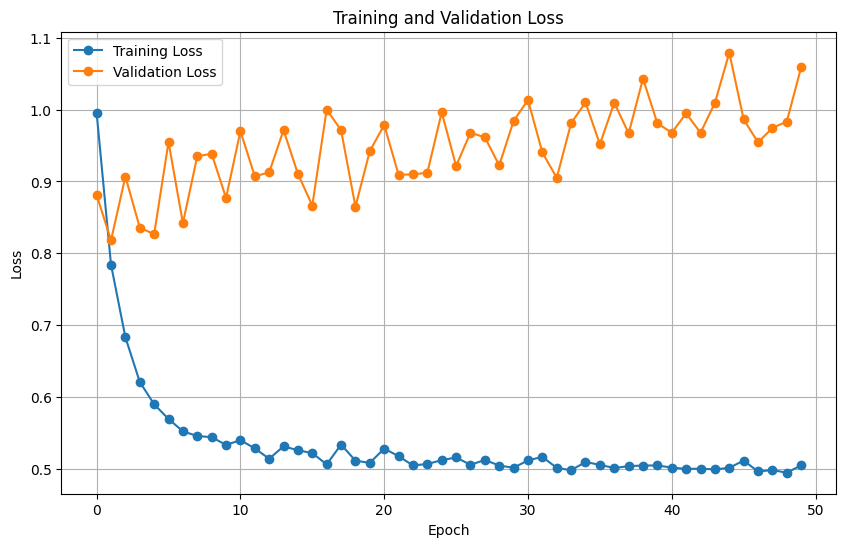

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
checkpoint_path = '/content/drive/My Drive/Colab/checkpointLMLoss.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Extract the model state dictionary
model_state_dict = checkpoint['model_state_dict']

# Load the model state dictionary into the model
model_lm.load_state_dict(model_state_dict)

<ipython-input-7-8c31b25b67f4>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


<All keys matched successfully>

In [ ]:
test_model(model_lm, test_loader, device)

Test Accuracy: 88.75%


In [ ]:
test1_model(model_ce, test_loader, device)

NameError: name 'test_model1' is not defined

In [ ]:
def memory_stats():
    print(torch.cuda.memory_allocated()/1024**2)
    print(torch.cuda.memory_reserved()/1024**2)


def allocate():
    x = torch.randn(1024*1024, device='cuda')
    memory_stats()

In [ ]:
memory_stats()

14666.77392578125
14746.0


In [ ]:
allocate()

14670.77392578125
14746.0


In [ ]:
torch.cuda.empty_cache()

In [ ]:
memory_stats()

13809.27197265625
13962.0


In [ ]:
torch.cuda.empty_cache()

In [ ]:
del model
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi


Fri Dec 13 16:47:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0              26W /  70W |  14097MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
import gc

# Example to clear memory
del model  # or any large tensors
gc.collect()
torch.cuda.empty_cache()

# Check memory status
!nvidia-smi


NameError: name 'model' is not defined